In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np

from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix

In [6]:
def direct_sum(A, B):
    # Check if both matrices A and B are two-dimensional
    if A.ndim != 2 or B.ndim != 2:
        raise ValueError("Both input arrays should be two-dimensional")
        
    # Create zero matrices that match the dimensions of the other input
    zero_A = np.zeros((A.shape[0], B.shape[1]))
    zero_B = np.zeros((B.shape[0], A.shape[1]))
    
    # Concatenate these matrices appropriately to get the direct sum
    top = np.hstack([A, zero_A]) # top part of the direct sum
    bottom = np.hstack([zero_B, B]) # bottom part of the direct sum
    
    return np.vstack([top, bottom]) # final direct sum

In [7]:
def generate_triangular_graph(i):
    G = nx.Graph()
    G.add_edge(2*i, 2*i+2)
    G.add_edge(2*i+1, 2*i+2)
    return G

def generate_reverse_triangular_graph(i):
    G = nx.Graph()
    # Add edges based on the repetition count
    G.add_edge(3*i+2, 3*i+3)
    G.add_edge(3*i+2, 3*i+4)
    return G

def rotation_matrix():
    # Define the permutation matrix
    P = np.array([
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]
    ])
    return P

In [104]:
def direct_sum_triangular_graph(repetitions):
    result_matrix = np.zeros((2,2))
    for i in range(repetitions):
        G = generate_triangular_graph(i)
        nodes = sorted(G.nodes())
        adjacency_matrix = nx.adjacency_matrix(G, nodelist=nodes).todense()        
        if i == 0:
            result_matrix = adjacency_matrix
        else:
            # Direct sum
            result_matrix = direct_sum(result_matrix, adjacency_matrix)

    return result_matrix

def direct_sum_reverse_triangular_graph(repetitions):
    # Initialize the result matrix to represent two disconnected nodes 0 and 1
    result_matrix = np.zeros((2,2))

    for i in range(repetitions-1):
        G = generate_reverse_triangular_graph(i)
        nodes = sorted(G.nodes())
        adjacency_matrix = nx.adjacency_matrix(G, nodelist=nodes).todense()
        
        # Direct sum
        result_matrix = direct_sum(result_matrix, adjacency_matrix)
    
    # After all repetitions, add an additional disconnected node
    result_matrix = direct_sum(result_matrix, np.zeros((1,1)))
    return result_matrix

def direct_sum_rotation_matrix(repetitions):
    p = rotation_matrix()
    result_matrix = p
    for i in range(repetitions-1):
        p = rotation_matrix()
        result_matrix = direct_sum(result_matrix, p)

    return result_matrix

In [105]:
def rotate_triangular(adjm,rotMat):
    rotated_matrix = np.dot(rotMat, np.dot(adjm, rotMat.T))
    return rotated_matrix

def generate_temporal_helix(repetitions,timeSteps):
    triangularGraphMatrix = direct_sum_triangular_graph(repetitions=repetitions)
    reverseTriangularGraphMatrix = direct_sum_reverse_triangular_graph(repetitions=repetitions)
    
    graphMatrix = triangularGraphMatrix + reverseTriangularGraphMatrix
    
    rotationMatrix = rotation_matrix_direct_sum(repetitions)
    
    result_matrix = graphMatrix
    for _ in range(timeSteps):
        result_matrix = rotate_triangular(result_matrix,rotationMatrix)
    return result_matrix

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0.]]

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1. 0.]]


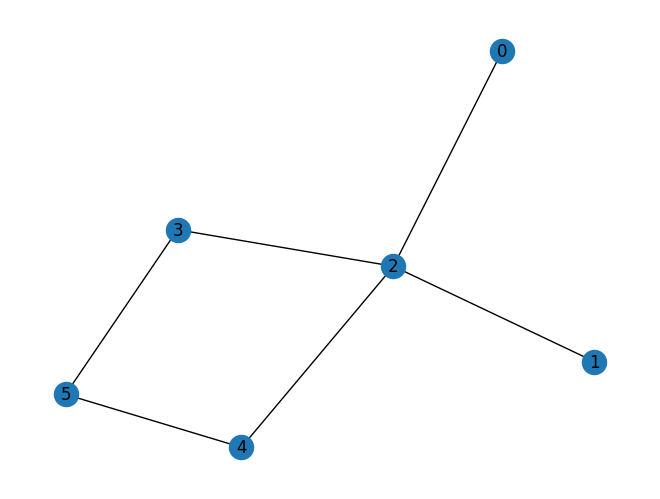

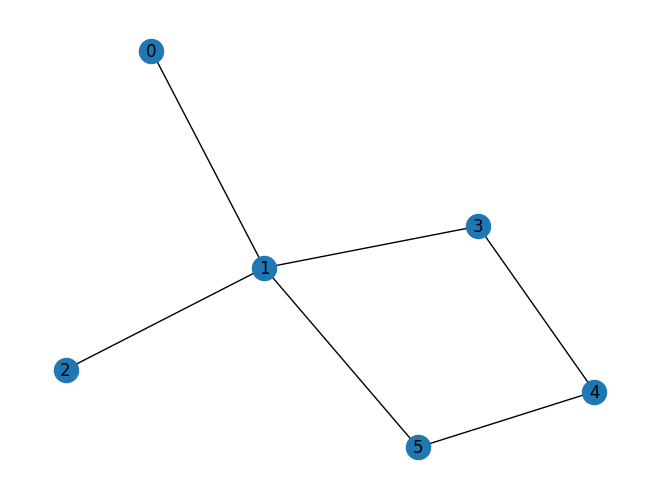

In [106]:
temporal_helix = generate_temporal_helix(2,0)
temporal_helix2 = generate_temporal_helix(2,1)
print(temporal_helix)
print()
print(temporal_helix2)
draw_graph_from_adjacency_matrix(temporal_helix)
draw_graph_from_adjacency_matrix(temporal_helix2)

In [117]:
import numpy as np
import networkx as nx
from scipy.linalg import block_diag

def add_new_vertex(adj_matrix, connect_to_vertices):
    """
    Adds a new vertex to the adjacency matrix and connects it to the specified vertices.
    """
    num_vertices = adj_matrix.shape[0] 
    # Create an extended adjacency matrix
    extended_adj_matrix = np.zeros((num_vertices + 1, num_vertices + 1))
    # Copy the original adjacency matrix into the extended one
    extended_adj_matrix[1:, 1:] = adj_matrix
    # Add connections from the new vertex to the specified vertices
    for vertex in connect_to_vertices:
        extended_adj_matrix[0, vertex + 1] = extended_adj_matrix[vertex + 1, 0] = 1

    return extended_adj_matrix

def extend_rotation_matrix(rot_matrix):
    """
    Extends the rotation matrix with an additional row and column populated with an identity matrix,
    thereby ensuring that the added vertex is not rotated.
    """
    num_vertices = rot_matrix.shape[0]
    # Create an extended rotation matrix
    extended_rot_matrix = np.zeros((num_vertices + 1, num_vertices + 1))
    # Copy the original rotation matrix into the extended one
    extended_rot_matrix[1:, 1:] = rot_matrix
    # Add identity element to the top-left corner of the extended rotation matrix
    extended_rot_matrix[0, 0] = 1

    return extended_rot_matrix

def add_new_vertex_at_end(adj_matrix, connect_to_vertex):
    """
    Adds a new vertex to the adjacency matrix and connects it to the specified vertex.
    """
    num_vertices = adj_matrix.shape[0] 
    # Create an extended adjacency matrix
    extended_adj_matrix = np.zeros((num_vertices + 1, num_vertices + 1))
    # Copy the original adjacency matrix into the extended one
    extended_adj_matrix[:-1, :-1] = adj_matrix
    # Add connection from the new vertex to the specified vertex
    extended_adj_matrix[-1, connect_to_vertex] = extended_adj_matrix[connect_to_vertex, -1] = 1

    return extended_adj_matrix

def extend_rotation_matrix_at_end(rot_matrix):
    """
    Extends the rotation matrix with an additional row and column populated with an identity matrix,
    thereby ensuring that the added vertex is not rotated.
    """
    num_vertices = rot_matrix.shape[0]
    # Create an extended rotation matrix
    extended_rot_matrix = np.zeros((num_vertices + 1, num_vertices + 1))
    # Copy the original rotation matrix into the extended one
    extended_rot_matrix[:-1, :-1] = rot_matrix
    # Add identity element to the bottom-right corner of the extended rotation matrix
    extended_rot_matrix[-1, -1] = 1

    return extended_rot_matrix

def generate_temporal_helix(repetitions, timeSteps):
    triangularGraphMatrix = direct_sum_triangular_graph(repetitions=repetitions)
    reverseTriangularGraphMatrix = direct_sum_reverse_triangular_graph(repetitions=repetitions)

    graphMatrix = triangularGraphMatrix + reverseTriangularGraphMatrix

    # Add new vertex that is connected to the first two vertices
    graphMatrix = add_new_vertex(graphMatrix, connect_to_vertices=[0, 1])

    rotationMatrix = direct_sum_rotation_matrix(repetitions)
    # Extend the rotation matrix to accommodate the new vertex
    rotationMatrix = extend_rotation_matrix(rotationMatrix)

    # Add another new vertex that is connected only to the first vertex of the previous structure (vertex 0)
    graphMatrix = add_new_vertex(graphMatrix, connect_to_vertices=[0])
    graphMatrix = add_new_vertex_at_end(graphMatrix, connect_to_vertex=graphMatrix.shape[0] - 1)
    # Extend the rotation matrix to accommodate the new vertex
    rotationMatrix = extend_rotation_matrix(rotationMatrix)
    rotationMatrix = extend_rotation_matrix_at_end(rotationMatrix)

    result_matrix = graphMatrix
    for _ in range(timeSteps):
        result_matrix = rotate_triangular(result_matrix, rotationMatrix)

    return result_matrix, rotationMatrix


[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]]


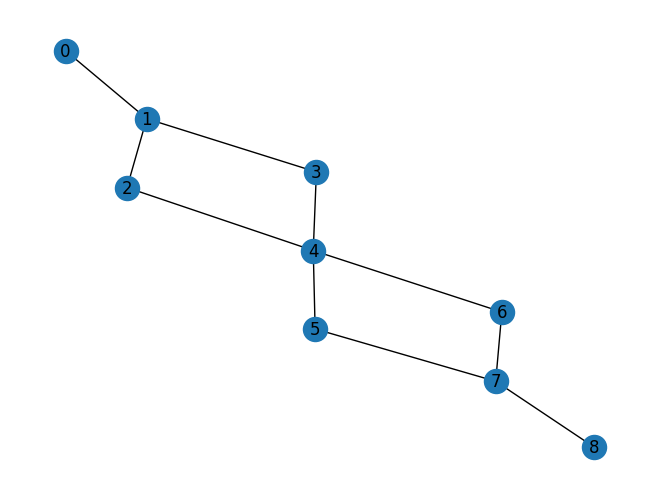

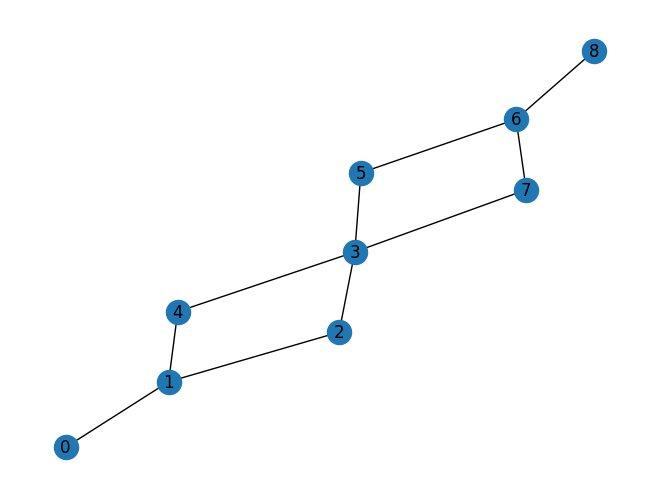

In [118]:
temporal_helix,a = generate_temporal_helix(2,0)
temporal_helix2,b = generate_temporal_helix(2,1)
print(temporal_helix)
print()
print(temporal_helix2)
draw_graph_from_adjacency_matrix(temporal_helix)
draw_graph_from_adjacency_matrix(temporal_helix2)